# SIADS 593 - Milestone 1

*By: Aaron Dankert and Luis Gallego*

*Winter 2024*

# Introduction

## Motivation

## Limitations

# Installation

## Dependencies

In [1]:
# !pip install -q -r requirements.txt

## Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pycountry
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy
import warnings
from collections import defaultdict
from scipy.stats import norm
from func_library import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
np.random.seed(42)

# Data Cleaning and Manipulation

We are putting all of our functions and objects into our special `func_library.py`. This is to prevent this notebook from getting too long with repetitive functions and classes. Cleaning larger data sets are placed into their own objects and use specific methods to generate the dataframe.

# Load Data

In [3]:
stack_overflow, skills_list, employments = StackOverflowData.generate_aggregate_df(only_data_science_devs=True)
exchange_rate_df = generate_exchange_rates_df()
ppp_df = read_ppp()
stack_overflow = StackOverflowData.generate_2023_usd_comp(stack_overflow, exchange_rate_df, ppp_df)

ai_salaries_df = AISalariesData.generate_df()
ai_salaries_df = AISalariesData.generate_2023_usd_comp(ai_salaries_df, exchange_rate_df, ppp_df)
ai_salaries_df = pd.concat([ai_salaries_df, pd.get_dummies(ai_salaries_df["job_title"], dtype='int')], axis=1)
ai_salaries_df = ai_salaries_df.drop("job_title", axis=1)

ai_salaries_df = ai_salaries_df.dropna(subset=['usd_2023'])
stack_overflow = stack_overflow.dropna(subset=['usd_2023'])

In [4]:
# prevent outliers for our purposes for this data frame
relevant_skills = [skill for skill in skills_list if "hww" in skill]
stack_overflow["total_skills"] = stack_overflow[relevant_skills].sum(axis=1)
q3 = stack_overflow["usd_2023"].quantile(0.75)
IQR = stack_overflow["usd_2023"].quantile(0.75) - stack_overflow["usd_2023"].quantile(0.25)
stack_overflow = stack_overflow[stack_overflow["usd_2023"] < q3 + (1.5*IQR)]

s_o = stack_overflow.drop(skills_list, axis=1)

# important otherwise we get lots of categorical variables later on
s_o["edlevel"] = s_o["edlevel"].replace({
    "Some College": "<=Bachelor's",
    "Associate's": "<=Bachelor's",
    "Secondary": "<=Bachelor's",
    "Elementary": "<=Bachelor's",
    "Else": "<=Bachelor's",
    "Bachelor's": "<=Bachelor's"
})

# also for our purposes we need to standardize this to integers
s_o["yearscodepro"] = s_o["yearscodepro"].replace({'Less than 1 year': 0, 'More than 50 years': 50})
s_o["yearscodepro"] = s_o["yearscodepro"].fillna(0)
s_o["yearscodepro"] = s_o["yearscodepro"].astype(int)
s_o["experience_level"] = pd.cut(
                                x=s_o["yearscodepro"], 
                                bins=[0, 2, 5, 10, np.inf],
                                labels=['Entry', 'Middle', 'Senior', 'Executive']
                            )

## Combine

In [5]:
# make sure the columns are equal so that we can vertically concatenate
temp_so = s_o[["year", "experience_level", "country", "usd_2023"] + list(employments)]
temp_ai = ai_salaries_df[["work_year", "experience_level", "employee_residence", "usd_2023"] + list(employments)]
temp_ai.columns = temp_so.columns

# concatenate
merged = pd.concat([temp_so, temp_ai], axis=0, ignore_index=True)

# get rid of outliers
IQR = merged["usd_2023"].quantile(0.75) - merged["usd_2023"].quantile(0.25)
q3 = merged["usd_2023"].quantile(0.75)

# curious about number of outliers
outliers = merged[merged['usd_2023'] > q3 + (1.5*IQR)]
print(f"Outliers: {len(outliers)} vs. Normal: {len(merged)}")

# now get rid of outliers
merged = merged[merged['usd_2023'] < q3 + (1.5*IQR)]

# final data manipulation, these were strings and below were abbreviations initially
merged.loc[:, "year"] = merged.loc[:, "year"].astype('int64')
merged["experience_level"] = merged["experience_level"].replace({'SE': 'Senior', 'MI': 'Middle', 'EN': 'Entry', 'EX': 'Executive'})

Outliers: 589 vs. Normal: 53158


# Analysis

## Helper Functions and Other Helpers (best to keep the cells hidden after viewing)

In [6]:
alpha2_to_name = {country.alpha_2: country.name for country in pycountry.countries}

In [7]:
def get_similar_countries(df: pd.DataFrame, want: int = 10) -> list:
    """
    Get the number of countries that we want so we can index for ANOVA
    Consistent across the years for a good comparison
    """
    groupped = df.groupby('year')
    loc_list = list()
    head = want
    
    while len(loc_list) < want:
        loc_set = set()
        for year, frame in groupped:
            grouped = frame.groupby("country").size().sort_values(ascending=False)
            if not loc_set:
                loc_set = set(grouped.head(head).index)
                continue
            temp_set = set(grouped.head(head).index)
            loc_set = loc_set.intersection(temp_set)
        loc_list = list(loc_set)
        head += 1
    return loc_list

In [8]:
def generate_stacked_barchart(merged, countries):
    groupped = merged.groupby("year")
    dfs = []
    for year, frame in groupped:
        t_tests = np.zeros((len(countries), len(countries)))
        frame = frame[frame["country"].isin(countries)]
        for i in range(len(countries)):
            control = countries[i]
            for j in range(i+1, len(countries)):
                exp = countries[j]
                d1 = frame[frame["country"] == control]
                d2 = frame[frame["country"] == exp]
                result = pg.ttest(d1.usd_2023, d2.usd_2023).round(3) # this is 2 tailed
                t_tests[j, i] = result.loc["T-test", "p-val"]
        df = pd.DataFrame(t_tests, columns=countries, index=countries)
        dfs.append(df)
        
    stat_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
    year = 2019
    for df in dfs:
        for start in range(len(df)):
            r = start
            c = 0
            dec_row = False
            while c < len(df) and r < len(df):
                if r == c: # then we are on the diagonal
                    dec_row = True
                    r += 1
                    continue
    
                row = df.index[r]
                col = df.columns[c]
                if df.iloc[r, c] < 0.05:
                    val = 1
                else:
                    val = 0
                        
                if not dec_row: # we are going across
                    stat_counts[str(year)][row][col] = val
                    c += 1
                else:
                    stat_counts[str(year)][col][row] = val
                    r += 1
        year += 1
    result = {}
    for year, count_dict in stat_counts.items():
        counts = [] 
        for key, value in count_dict.items():
            counts.append((key, sum(value.values())))
        result[year] = counts
    
    transformed_data = {}
    for key, tuples in result.items():
        for tup in tuples:
            index, value = tup[0], tup[1]
            if index not in transformed_data:
                transformed_data[index] = {}
            transformed_data[index][key] = value
    
    # Create DataFrame
    working = pd.DataFrame.from_dict(transformed_data, orient='index')
    working["total"] = working[["2019", "2020", "2021", "2022", "2023"]].sum(axis=1)
    working = working.sort_values("total", ascending=False)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    working.index = [alpha2_to_name[country] for country in working.index]
    working[["2019", "2020", "2021", "2022", "2023"]].plot(kind="barh", stacked=True, ax=ax)
    ax.set_title("Number of Statistically Significant Differences Among Countries")
    ax.set_xlabel('count')
    
    # https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
    y_offset = -0.4
    for bar in ax.patches:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + bar.get_y() + y_offset,
          round(bar.get_width()),
          ha='center',
          color='k',
          size=9
      )
    
    plt.show()

In [9]:
def cull_country(frame: pd.DataFrame, cull_factor=20) -> set:
    """
    Given a particular minimum (cull_factor) find the countries in common among
    frames.
    """
    union = []
    grouped = frame.groupby("country").count()
    grouped = grouped[grouped["year"] > cull_factor]
    return list(grouped.index)

In [10]:
countries = get_similar_countries(merged, 20)

# now we sort the countries by overall averages for later use
sort = merged[merged["country"].isin(countries)].groupby("country")["usd_2023"].mean().sort_values()
countries = list(sort.index)

## Mean Compensation Estimates for Represented Countries

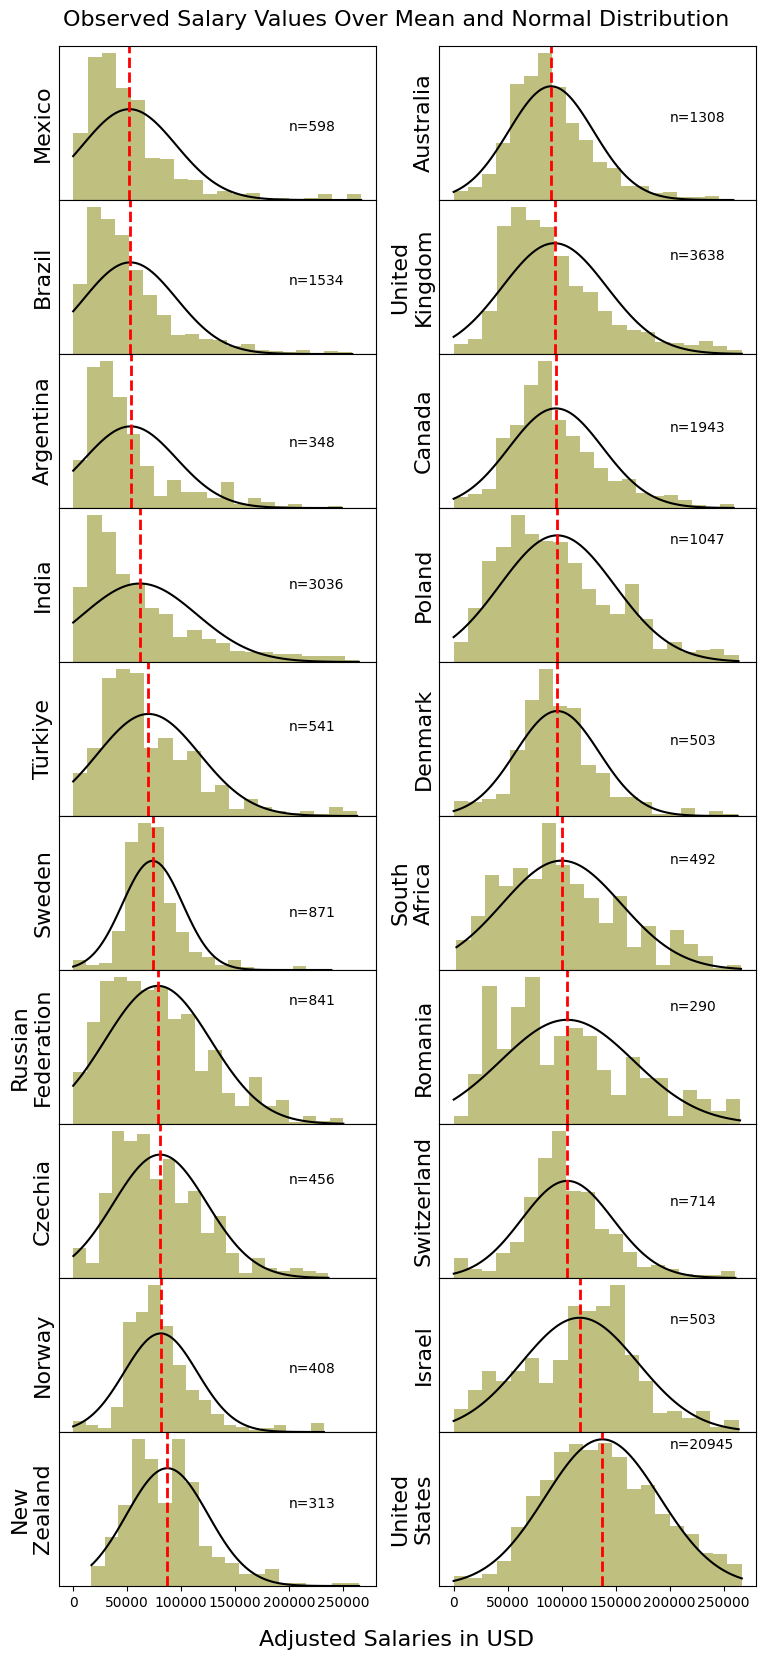

In [21]:
first_half = countries[:len(countries)//2]
second_half = countries[len(countries)//2:]
length = max(len(first_half), len(second_half))

fig, axes = plt.subplots(length, 2, sharex=True, figsize=(9, 20))
for i in range(length):
    working = merged[merged["country"] == first_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"])
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 0].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 0].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel("\n".join(alpha2_to_name[first_half[i]].split(" ")), fontsize=16)
    axes[i, 0].text(200000, 7e-6, f"n={len(working)}")

    working = merged[merged["country"] == second_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"])
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 1].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 1].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 1].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 1].set_yticks([])
    axes[i, 1].set_ylabel("\n".join(alpha2_to_name[second_half[i]].split(" ")), fontsize=16)
    axes[i, 1].text(200000, 7e-6, f"n={len(working)}")

fig.text(0.5, 0.08, 'Adjusted Salaries in USD', ha='center', fontsize=16)
fig.text(0.5, 0.89, 'Observed Salary Values Over Mean and Normal Distribution', ha='center', fontsize=16)

plt.subplots_adjust(hspace=0)
plt.show()

Above we have the actual distributions in olive with the normal overlayed in black; the mean salary from 2019-2023 is in a dashed red line. We can see that the chart reads from top to bottom, and once at the bottom to the right then top to bottom again. It can be seen that very large samples, like in the US, result in an almost normal distribution, while smaller values are skewed right, like in Romania. An exception to this is India where it it heavily skewed right, as opposed to the Great Britain which has a comparable number of responses.

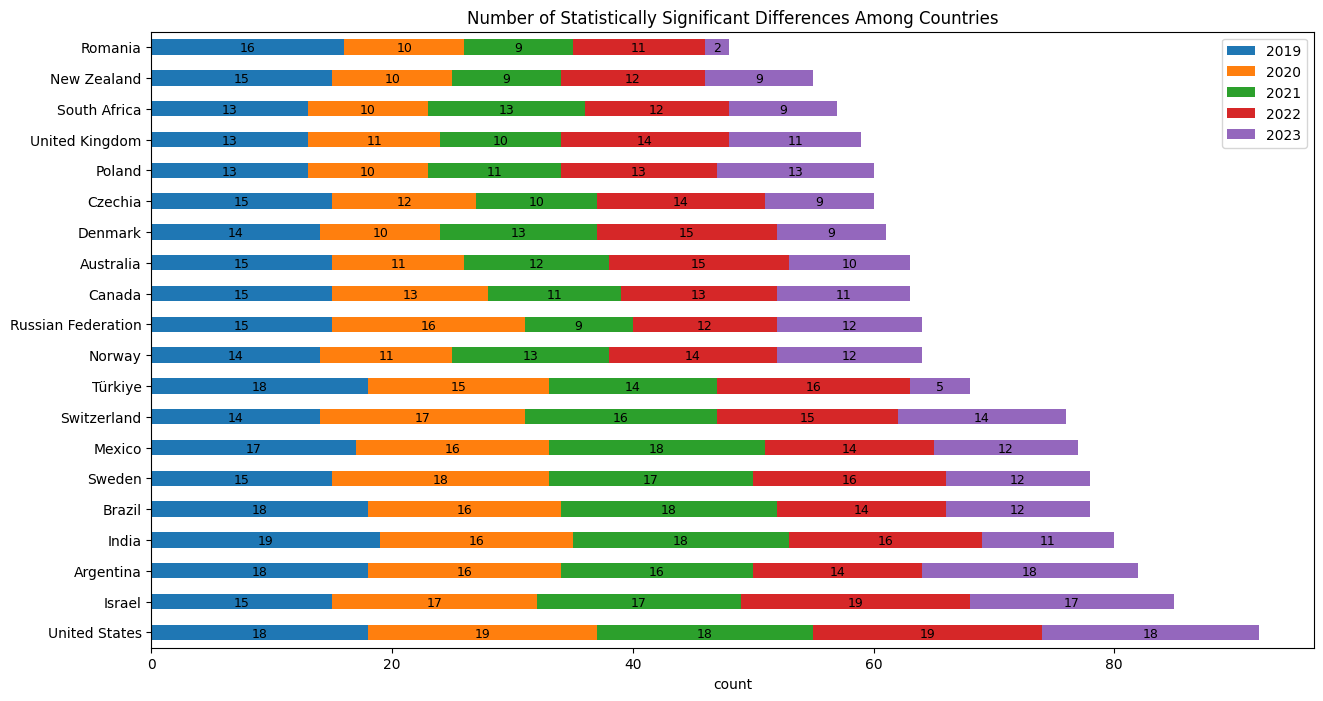

In [12]:
generate_stacked_barchart(merged, countries)

This bar chart, is complicated in the sense that the higher the number the more statistically significant differences there are. T-tests were done on each combination and this bar chart was created after ordering the total number of differences. Year is encoded by color. Unsurprisingly, the US was at the top, likely because of it's high salaires, and so was India and Brazil even more surprisingly. If we take a look at some of these means.

In [28]:
for c in countries:
    print(f"{c} mean: ${merged[merged['country'] == c]['usd_2023'].mean()}")

MX mean: $52083.77108290236
BR mean: $52872.06399910461
AR mean: $53207.20330396543
IN mean: $61794.92766168061
TR mean: $69760.527087333
SE mean: $73512.68346795124
RU mean: $78470.96430112084
CZ mean: $80593.48206995858
NO mean: $81110.80221203179
NZ mean: $87176.07756011485
AU mean: $90280.45016153267
GB mean: $93445.7249197411
CA mean: $94690.95767361697
PL mean: $95937.44855105618
DK mean: $96020.04283997793
ZA mean: $100098.83155691
RO mean: $105186.19248057486
CH mean: $105321.66627248378
IL mean: $116717.77724709858
US mean: $137757.56853992204


Now we get a more definitive look as to why the US and Israel have such big differences. While Romania does not despite having a comparable overall mean. Looking at the first figure we see that Romania has a sample of 290 vs the US of more than 20,000. This factors into the equation of the t-test where the standard deviation is divided by the sample size (n). Large values of n mean that deviations from the null hypothesis (that both populations have the same mean) have a statistical effect than smalle samples do, or that's it's less uncertain the smaller the sample size. It's likely that given this fact and Romania's distribution, that when compared to other small sampled countries that the effects described earlier are smaller than than when compared to the US's.

We see the same with India as the sample size is much larger than othe countries.

## Worldwide Compensation Trends Map

In [13]:
# choropleth

## Percent Changes in Countries Per Year

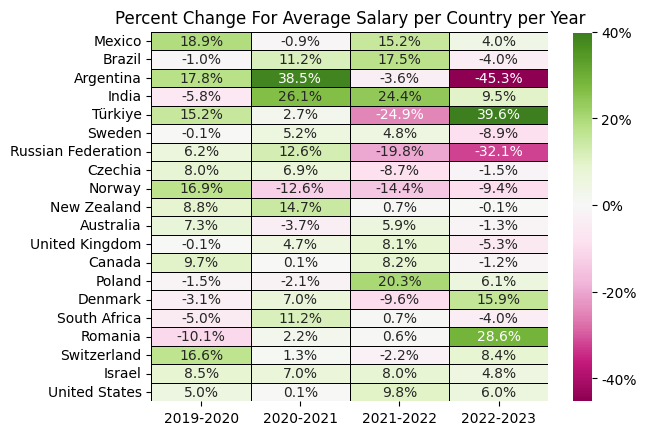

In [14]:
pivot = pd.pivot_table(merged, values="usd_2023", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
pivot.index = [alpha2_to_name[country] for country in pivot.index]

plt.title("Percent Change For Average Salary per Country per Year")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.4,  -0.2, 0, 0.2, 0.4])
cbar.set_ticklabels(['-40%', '-20%', '0%', '20%', '40%'])
plt.show()

A deeper dive into the changer per year instead of the overall 2019-2023 gives us more actinable insights. This allows data professionals to see where their skills are most valued and where there is volatility. It can be seen that Argentina and Russia have the most volatility with their salaries. These relatively large increases with salary may not have to do with the skills that data professionals but rather with the volatile economies of these countries.

Russia invaded Ukraine in these years and as a result we see the sharp decreases in salary as their economy collapsed. Argentina on the other hand has been under economic distress and saw growth in salaries the last year it saw GDP growth. 

In [15]:
relevant_skills = [skill for skill in skills_list if "hww" in skill]
stack_overflow["total_skills"] = stack_overflow[relevant_skills].sum(axis=1)

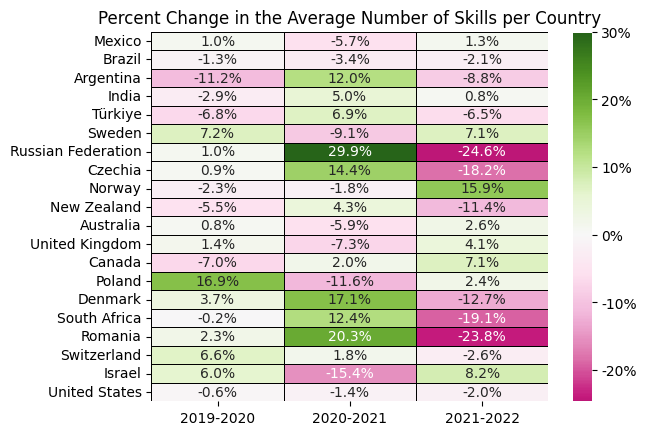

In [16]:
pivot = pd.pivot_table(stack_overflow, values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
pivot.index = [alpha2_to_name[country] for country in pivot.index]

plt.title("Percent Change in the Average Number of Skills per Country")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.2, -0.10, 0, 0.1, 0.2, 0.3])
cbar.set_ticklabels(['-20%', '-10%', '0%', '10%', '20%', '30%'])
plt.show()

This heatmap and the ones below did not make it into our slides due to space constraints. But we can still extract insights here. We see that ordering by the overall means still holds here, so we can see how skills change over time. Above we created the `total_skills` column in the `stack_overflow` data frame for use to get this pivot table turned into a heat map. We see a decline in skills in the US, likely because of the growth in low or no code options over the recent years that the StackOverflow survey did not cover. We also see that any relatively large increase in skills comes with its own sharp decrease from that year, notably in Romania and Russia. This could be due to sampling bias or the invasion of Ukraine in Russia's case. Sampling bias is hypothesized because 2023 is not included in this chart. This is because we get sharp decreases across all countries due to the size. Below it can be seen.

In [30]:
stack_overflow.groupby('year')['count'].count()

year
2019    15436
2020    10306
2021     8686
2022     6410
2023     2330
Name: count, dtype: int64

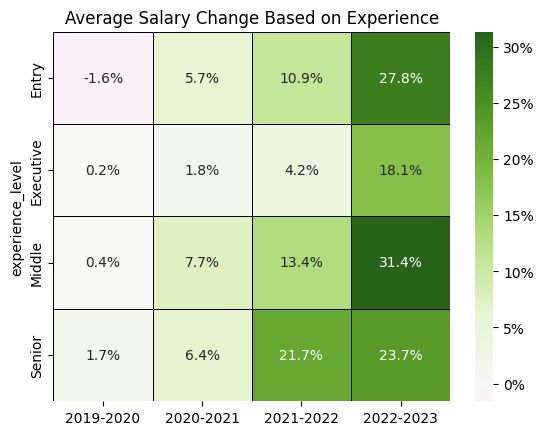

In [17]:
pivot = pd.pivot_table(merged, values="usd_2023", index="experience_level", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change Based on Experience")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3])
cbar.set_ticklabels(['0%', '5%', '10%', '15%', '20%', '25%', '30%'])
plt.show()

Even further we can granularize the merged salary data into their respective salary change based on experience. The stack overflow data required binning the years of experience, which were integers, into categories, which were named into what is seen here and is as follows:
- 0-2 years = entry
- 2-5 years = middle
- 5-10 years = senior
- +10 years = executive

Worldwide we see enormous growths in salary across all experience levels., especially among the middle level data professionals.

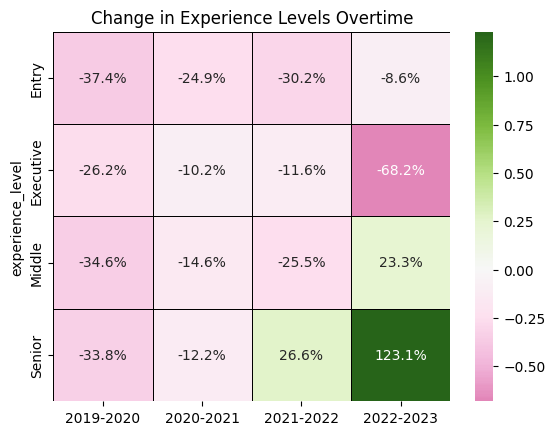

In [18]:
pivot = pd.pivot_table(merged, values="usd_2023", index="experience_level", columns="year", aggfunc="count")
pivot = pivot.dropna()
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)

plt.title("Change in Experience Levels Overtime")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

Counting the number of experience levels and getting the percent change nets us the complete opposite of what is above. Mostly we see drops in the number of these experience levels. This is counter intuitive since with less people in these categories we see a much larger increase in salaries. We can say that the salaries are increasing for entry level and executive positions, while the number of these positions, or people who hold them, are decreasing. Decreasing due to not wanting the job any more or switching careers is unsure. Stranger so, it's seen that the senior level has a dramatic increase of more than doubling between 2022-2023.

This chart does not capture any changes of individuals incrementing their experience level, and would be impossible given we don't have personal data, and it would be unethical for this analysis, since it's not needed.

## Levels of Degree and Experience

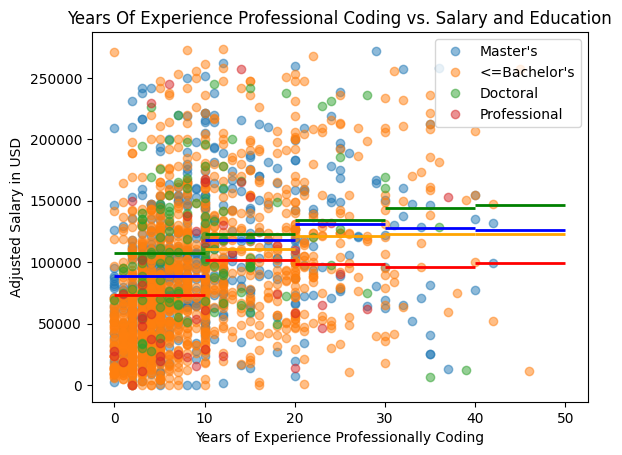

In [19]:
edu = s_o[~s_o["edlevel"].isin(['nan'])]
knots = [0, 10, 20, 30, 40, 50]
colors = {"Master's": "blue", "<=Bachelor's": "orange", "Doctoral": "green", "Professional": "red"}
for school in edu["edlevel"].unique():
    temp = edu[edu["edlevel"] == school].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=school, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = edu[edu["yearscodepro"].between(gt, lt)].groupby('edlevel')["usd_2023"].mean()
        plt.hlines(grouped[school], xmin=lt, xmax=gt, color=colors[school], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Education")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc="best")
plt.show()

Though a noisy chart, this is the sampled version from the code snippet above. Otherwise, this would be incredibly noisy. The mark bars are the mean for this education level, where anythin less than a bachelor's is grouped together, which is also why it's the largest group. Doctoral degrees dominate the salary to no surprise due to the rigor of this degree. The education salary data is as expected following doctoral degrees, then masters, then bachelor's or less. Surprisingly, professional education last. Professional education is surprisingly in this data, which can include doctors and those who completed law school. These respondents have the lowest salary, consistently. Likely due to their education not being in a computer focused curriculum, and they switched to some sort of data profession. Or they may happen to code in their free time and use StackOverflow.

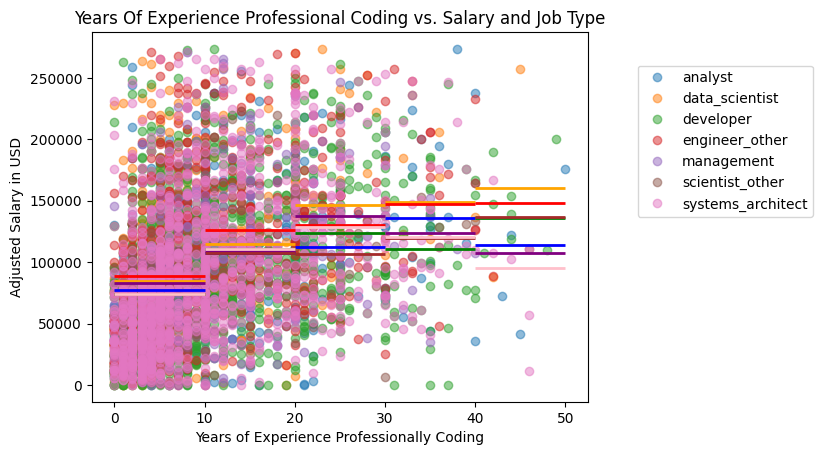

In [34]:
knots = [0, 10, 20, 30, 40, 50]
colors = {
    "analyst": "blue", 
    "data_scientist": "orange", 
    "developer": "green", 
    "engineer_other": "red", 
    "management": "purple", 
    "scientist_other": "brown", 
    "systems_architect": "pink"
}
for job in employments:
    temp = s_o[s_o[job] == 1].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=job, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = temp[temp["yearscodepro"].between(gt, lt)]["usd_2023"].mean()
        plt.hlines(grouped, xmin=lt, xmax=gt, color=colors[job], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Job Type")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc=(1.1, 0.5))
plt.show()

Machine learning engineers and other kinds of engineers were grouped into the engineer_other category. We see that early in the career that engineers dominate, then as time goes on we see data scientists dominating the salaries with engineers. This is likely to the boom in data scientists resulting in more people with experience to mentor those within the workplace. Analysts are lower on the average salary for our time ranges, as well as system architects. This is strange considering how closely an analysts job is with a data scientists, as well as the need for cloud and system architects in a growing digital world.

# References